![image.png](https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcQd3Hh1G38iYDWP1wA6IyIdHIRskk8QaXhoI09YbDc3FgIBSaBL3fUL02BncHxJuVPazQ&usqp=CAU)


Специализация: Data Science   
Группа: DST-29   
Юнит 3. Проект: «О вкусной и здоровой пище»   
Выполнила: Марина Розова   

**Задание:** Необходимо построить модель которая предсказывает рейтинг ресторана TripAdvisor




Первоначальная версия датасета состоит из десяти столбцов, содержащих следующую информацию:

- Restaurant_id — идентификационный номер ресторана / сети ресторанов;
- City — город, в котором находится ресторан;
- Cuisine Style — кухня или кухни, к которым можно отнести блюда, предлагаемые в ресторане;
- Ranking — место, которое занимает данный ресторан среди всех ресторанов своего города;
- Rating — рейтинг ресторана по данным TripAdvisor (именно это значение должна будет предсказывать модель);
- Price Range — диапазон цен в ресторане;
- Number of Reviews — количество отзывов о ресторане;
- Reviews — данные о двух отзывах, которые отображаются на сайте ресторана;
- URL_TA — URL страницы ресторана на TripAdvosor;
- ID_TA — идентификатор ресторана в базе данных TripAdvisor.

# 1 Загрузка библиотек и датасета

In [110]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import combinations
from scipy.stats import ttest_ind
from collections import Counter
import pandas_profiling
import re
from datetime import datetime, timedelta
import pandas_profiling
import matplotlib.pyplot as plt
import seaborn as sns

In [111]:
pd.set_option('display.max_rows', 50)
pd.set_option('display.max_columns', 50)
import warnings; warnings.simplefilter('ignore')

# зафиксируем random_seed
RANDOM_SEED = 42

# зафиксируем версию пакетов
!pip freeze > requirements.txt

In [147]:
df = pd.read_csv('main_task.csv')


## Определение функций

In [148]:
# определение количества пропусков в датасете
def missing_values_table(df):
    # Всего отсутствующих значений
    mis_val = df.isnull().sum()

    # Процент пропущенных значений
    mis_val_percent = 100 * df.isnull().sum() / len(df)

    # Составим таблицу с результатами
    mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)

    # Переименуем столбцы
    mis_val_table_ren_columns = mis_val_table.rename(
        columns={0: 'Пропуски', 1: '% пропусков'})

   # Отсортируем таблицу по проценту пропущенных по убыванию
    mis_val_table_ren_columns = mis_val_table_ren_columns[
        mis_val_table_ren_columns.iloc[:, 1] != 0].sort_values(
        '% пропусков', ascending=False).round(1)

    # Выведем таблицу на экран
    print("В нашем датафрейме " + str(df.shape[1]) + " столбцов.\n"
          "В " + str(mis_val_table_ren_columns.shape[0]) +
          " колонках есть пропущенные данные.")

    # Вернуть фрейм данных с отсутствующей информацией
    return mis_val_table_ren_columns

# замена значений в столбце цены


def price_ord(row):
    price_dict = {'$': 1, '$$ - $$$': 2, '$$$$': 3}
    row = row.replace(to_replace=price_dict)
    return row


# построение гистограмм для числовых данных
def numerical(col):
    ''' Построение гистограммы и вывод основных 
    статистических данных цифровых признаков 
    '''
    display(df[col].hist(bins=100))
    display(df[col].describe())

#  вывод основных показателей для категориальных данных


def categorical(col):
    ''' Вывод основных статистических данных 
    категориальных признаков
    '''
    display(pd.DataFrame(df[col].value_counts()))
    display(df[col].describe())

#  очистка столбца с кухнями и замена NaN на Uknown


def cuisine(name):
    if pd.isna(name):
        return ['Uknown']
    name = name.strip('[]')
    name = name.replace("\'", '')
    name = name.split(', ')
    return name

# абсолютный рейтинг ресторана в городе
def rest_ranking(row, summ):
    for i in summ.keys():
        if row['City'] == i:
            res = row['Ranking']/rest[i]
    return res

# поиск выбросов
def outliers_iqr(ys):
    quartile_1, quartile_3 = np.percentile(ys, [25, 75])
    iqr = quartile_3 - quartile_1
    lower_bound = quartile_1 - (iqr * 1.5)
    upper_bound = quartile_3 + (iqr * 1.5)
    return np.where((ys > upper_bound) | (ys < lower_bound))[0]

# 2 Очистка данных

Посмотрим на данные

In [149]:
display(df.head(5))
df.info() 
df.columns

,Restaurant_id,City,Cuisine Style,Ranking,Rating,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA
0,id_5569,Paris,"['European', 'French', 'International']",5570.0,3.5,$$ - $$$,194.0,"[['Good food at your doorstep', 'A good hotel ...",/Restaurant_Review-g187147-d1912643-Reviews-R_...,d1912643
1,id_1535,Stockholm,NaN,1537.0,4.0,NaN,10.0,"[['Unique cuisine', 'Delicious Nepalese food']...",/Restaurant_Review-g189852-d7992032-Reviews-Bu...,d7992032
2,id_352,London,"['Japanese', 'Sushi', 'Asian', 'Grill', 'Veget...",353.0,4.5,$$$$,688.0,"[['Catch up with friends', 'Not exceptional'],...",/Restaurant_Review-g186338-d8632781-Reviews-RO...,d8632781
3,id_3456,Berlin,NaN,3458.0,5.0,NaN,3.0,"[[], []]",/Restaurant_Review-g187323-d1358776-Reviews-Es...,d1358776
4,id_615,Munich,"['German', 'Central European', 'Vegetarian Fri...",621.0,4.0,$$ - $$$,84.0,"[['Best place to try a Bavarian food', 'Nice b...",/Restaurant_Review-g187309-d6864963-Reviews-Au...,d6864963


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Restaurant_id      40000 non-null  object 
 1   City               40000 non-null  object 
 2   Cuisine Style      30717 non-null  object 
 3   Ranking            40000 non-null  float64
 4   Rating             40000 non-null  float64
 5   Price Range        26114 non-null  object 
 6   Number of Reviews  37457 non-null  float64
 7   Reviews            40000 non-null  object 
 8   URL_TA             40000 non-null  object 
 9   ID_TA              40000 non-null  object 
dtypes: float64(3), object(7)
memory usage: 3.1+ MB


Index(['Restaurant_id', 'City', 'Cuisine Style', 'Ranking', 'Rating',
       'Price Range', 'Number of Reviews', 'Reviews', 'URL_TA', 'ID_TA'],
      dtype='object')

**Отберем числовые колонки**

In [150]:
df_numeric = df.select_dtypes(include=[np.number])
numeric_cols = df_numeric.columns.values
print(numeric_cols)

['Ranking' 'Rating' 'Number of Reviews']


**Отберем нечисловые колонки**

In [151]:
df_non_numeric = df.select_dtypes(exclude=[np.number])
non_numeric_cols = df_non_numeric.columns.values
print(non_numeric_cols)

['Restaurant_id' 'City' 'Cuisine Style' 'Price Range' 'Reviews' 'URL_TA'
 'ID_TA']


Посмотрим количество пропусков:

In [152]:
missing_values_table(df)

В нашем датафрейме 10 столбцов.
В 3 колонках есть пропущенные данные.


,Пропуски,% пропусков
Price Range,13886,34.7
Cuisine Style,9283,23.2
Number of Reviews,2543,6.4


Рассмотрим для начала числовые колонки.  
Мы выяснили, что в двух из них есть пропущенные знаяения.

**Price Range**

Посмотрим на распределение в колонке

In [153]:
df_price = df['Price Range'].unique()
print(df_price)

['$$ - $$$' nan '$$$$' '$']


Заменим пропуски с вяроятностью появления значения цены.

In [154]:
mask = df['Price Range'].isna()
# считаем статистику распределения значений
p = df['Price Range'].value_counts()/len(df['Price Range'].dropna())
# заполняем пропуски с вероятностью p
df.loc[mask, 'Price Range'] = np.random.choice(
    p.index.to_list(), size=mask.sum(), p=p.to_list())

Создадим на основе значений столбца ординальный признак.

In [155]:
df['Price_ordinal'] = price_ord(df['Price Range'])                         

<AxesSubplot:>

count    40000.000000
mean         1.814225
std          0.509823
min          1.000000
25%          2.000000
50%          2.000000
75%          2.000000
max          3.000000
Name: Price_ordinal, dtype: float64

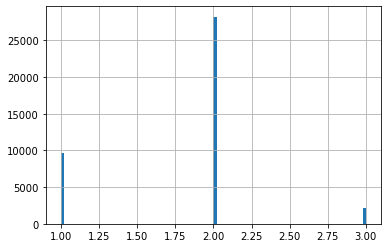

In [156]:
numerical('Price_ordinal')

Видно, что большинство ресторанов после замены пропусков, имеют среднюю ценовую категорию.

**Number of Reviews**

В данном столбце есть пропуски, заменим их на среднее значение по городу

In [157]:
df['Number of Reviews'] = df.groupby(['City']).transform(
    lambda x: x.fillna(x.mean()))['Number of Reviews']

И посмотрим на распределение

<AxesSubplot:>

count    40000.000000
mean       124.141837
std        286.333499
min          2.000000
25%         10.000000
50%         38.000000
75%        124.028861
max       9660.000000
Name: Number of Reviews, dtype: float64

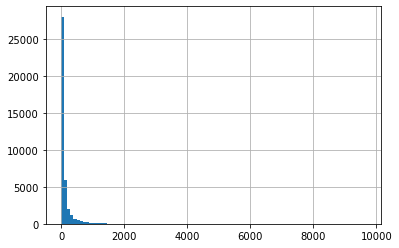

In [158]:
numerical('Number of Reviews')

Теперь посмотрим на столбцы с номинальными данными.

**Restaurant_id**

В данном признаке находится идентификатор ресторана, при этом в датасете представлены сетевые рестораны.

In [159]:
categorical('Restaurant_id')

,Restaurant_id
id_436,18
id_227,18
id_633,18
id_871,18
id_344,17
...,...
id_8560,1
id_14046,1
id_12948,1
id_8709,1


count      40000
unique     11909
top       id_436
freq          18
Name: Restaurant_id, dtype: object

На основе этих данных можем создать новый признак: 1 - сетевой ресторан, 0 - нет.

In [160]:
# создадим список ресторанов, которые относятся к сетевым
rest_network = df['Restaurant_id'].value_counts().loc[lambda x: x > 1].index

# создадим новый признак
df['Restaurant_network'] = df['Restaurant_id'].apply(
    lambda x: 1 if x in rest_network else 0)

<AxesSubplot:>

count    40000.000000
mean         0.882375
std          0.322168
min          0.000000
25%          1.000000
50%          1.000000
75%          1.000000
max          1.000000
Name: Restaurant_network, dtype: float64

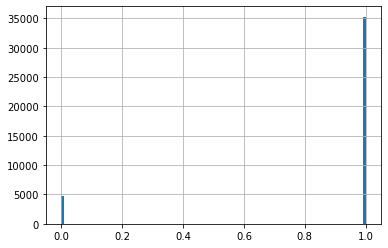

In [161]:
numerical('Restaurant_network')

**Cuisine Style**

In [162]:
# Найдем общее количество типов кухни без учета значения Uknown
df['Cuisine Style_1'] = df['Cuisine Style'].apply(cuisine)

cuisines_all = []
for data in df['Cuisine Style_1']:
    for cuisines in data:
        cuisines_all.append(cuisines)

cuisines = set()
for cuisin in cuisines_all:
    if cuisin != 'Uknown':
        cuisines.add(cuisin)
len(cuisines)

125

In [163]:
# Посмотрим на самые популярные кухни
cuisines_num = {}
for item in cuisines:
    cuisines_num[item] = 0
for cuisin in cuisines_all:
    if cuisin != 'Uknown':
        cuisines_num[cuisin] += 1

df_cuisines_num = pd.DataFrame.from_dict(cuisines_num,
                                         orient='index', columns=['num'])
df_cuisines_num.num.sort_values(ascending=False)

Vegetarian Friendly    11189
European               10060
Mediterranean           6277
Italian                 5964
Vegan Options           4486
                       ...  
Yunnan                     1
Latvian                    1
Salvadoran                 1
Xinjiang                   1
Burmese                    1
Name: num, Length: 125, dtype: int64

Добавим столбец, в котором будет хранится информация о количестве кухонь, представленных в ресторане 

In [174]:
df['Cuisine count'] = df['Cuisine Style_1'].apply(lambda x: len(x))

<AxesSubplot:>

count    40000.000000
mean         2.622400
std          1.817292
min          1.000000
25%          1.000000
50%          2.000000
75%          4.000000
max         21.000000
Name: Cuisine count, dtype: float64

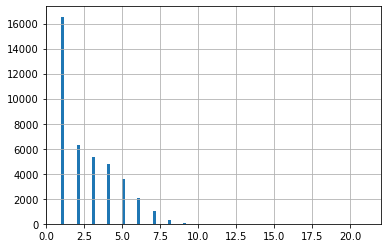

In [165]:
numerical('Cuisine count')

**City**

В данном столбце пропусков нет. Посмотрим сколько уникальных значений в столбце.

In [166]:
df_city = df['City'].unique()
df_city

array(['Paris', 'Stockholm', 'London', 'Berlin', 'Munich', 'Oporto',
       'Milan', 'Bratislava', 'Vienna', 'Rome', 'Barcelona', 'Madrid',
       'Dublin', 'Brussels', 'Zurich', 'Warsaw', 'Budapest', 'Copenhagen',
       'Amsterdam', 'Lyon', 'Hamburg', 'Lisbon', 'Prague', 'Oslo',
       'Helsinki', 'Edinburgh', 'Geneva', 'Ljubljana', 'Athens',
       'Luxembourg', 'Krakow'], dtype=object)

Создадим новый признак - является ли город столицей

In [167]:
city_capital = ['Paris', 'Stockholm', 'London', 'Berlin', 'Bratislava',
                'Vienna', 'Rome', 'Barcelona', 'Madrid', 'Dublin', 'Brussels',
                'Warsaw', 'Budapest', 'Copenhagen', 'Amsterdam', 'Hamburg',
                'Lisbon', 'Prague', 'Oslo', 'Helsinki', 'Ljubljana', 'Athens', 'Luxembourg']

df['City_capital'] = df['City'].apply(lambda x: 1 if x in city_capital else 0)

,City_capital
1,33511
0,6489


<AxesSubplot:>

count    40000.000000
mean         0.837775
std          0.368662
min          0.000000
25%          1.000000
50%          1.000000
75%          1.000000
max          1.000000
Name: City_capital, dtype: float64

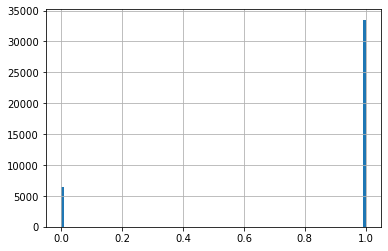

In [168]:
display(pd.DataFrame(df['City_capital'].value_counts()))
numerical('City_capital')

Добавим новый признак - рейтинг ресторана в городе, как отношение места ресторана к количеству всех ресторанов в городе

In [169]:
rest = dict(df['City'].value_counts())

df['Rank_abs'] = df.apply(lambda x: rest_ranking(x, rest), axis=1)

**Reviews**

Добавим новый признак разницу в днях между последними двумя отзывами

In [170]:
pattern = re.compile('\d+\/\d+\/\d+')
df['Reviews_date'] = df['Reviews'].apply(pattern.findall)
df['Reviews_date'] = df['Reviews_date'].apply(
    lambda x: [pd.to_datetime(i).date() for i in x])

df['First_date'] = df['Reviews_date'].apply(
    lambda x: x[0] if len(x) == 2 else 0)
df['Second_date'] = df['Reviews_date'].apply(
    lambda x: x[1] if len(x) == 2 else 0)

df['Time_delta'] = abs(df['Second_date']-df['First_date'])
df['Day_delta'] = df['Time_delta'].apply(
    lambda x: 0 if type(x) == int else x.days)

outliers = outliers_iqr(list(df['Day_delta']))

df['Day_delta'] = round(df['Day_delta'].replace(
    outliers, df['Day_delta'].mean()))

Добавим еще один признак - известность ресторана в городе - отношение отзывов к общему количеству отзывов в городе

In [171]:
all_reviews_city = df.groupby(['City'])['Number of Reviews'].sum().to_dict()
df['all_reviews_city'] = df['City'].map(all_reviews_city)
df['Repute_rest'] = np.array(df['Number of Reviews']) / \
    np.array(df.all_reviews_city)

In [172]:
df['City']

0            Paris
1        Stockholm
2           London
3           Berlin
4           Munich
           ...    
39995        Milan
39996        Paris
39997    Stockholm
39998       Warsaw
39999        Milan
Name: City, Length: 40000, dtype: object

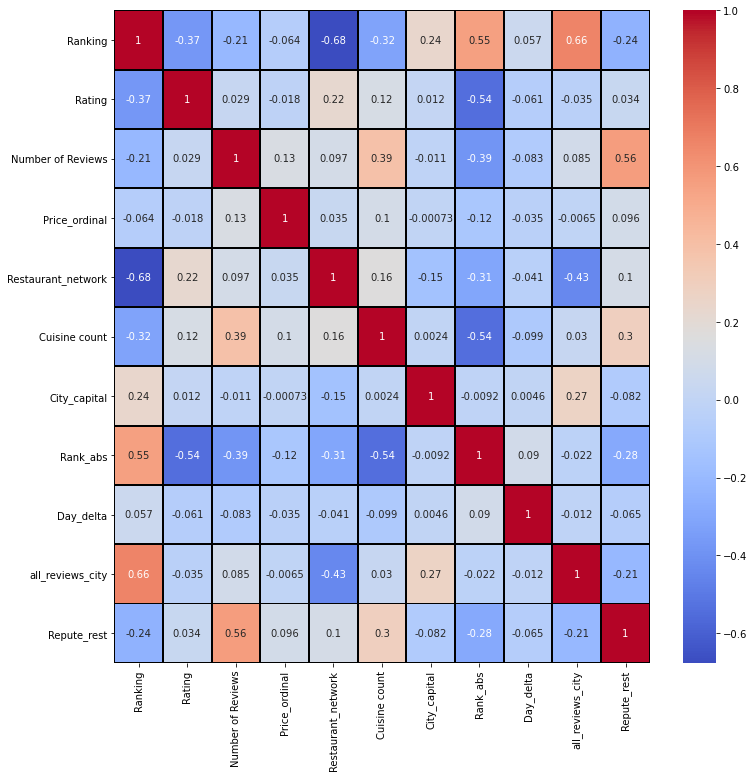

In [173]:
sns.heatmap(df.corr(),annot = True, cmap = 'coolwarm',
            linewidths=1, linecolor='black')
fig = plt.gcf()
fig.set_size_inches(12,12)

Теперь преобразуем признак City в dummy-переменные.

In [138]:
df = pd.get_dummies(df, columns=['City'])

In [139]:
df_1 = df.copy()

In [140]:
df_1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 53 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Restaurant_id       40000 non-null  object 
 1   Cuisine Style       30717 non-null  object 
 2   Ranking             40000 non-null  float64
 3   Rating              40000 non-null  float64
 4   Price Range         40000 non-null  object 
 5   Number of Reviews   40000 non-null  float64
 6   Reviews             40000 non-null  object 
 7   URL_TA              40000 non-null  object 
 8   ID_TA               40000 non-null  object 
 9   Price_ordinal       40000 non-null  int64  
 10  Restaurant_network  40000 non-null  int64  
 11  Cuisine Style_1     40000 non-null  object 
 12  Cuisine count       40000 non-null  int64  
 13  City_capital        40000 non-null  int64  
 14  Rank_abs            40000 non-null  float64
 15  Reviews_date        40000 non-null  object 
 16  Firs

удаляем ненужные столбцы

In [141]:
df_1 = df_1.drop(df_1.columns[[0,1,2,4,6,7,8,11,15,16,17,18]], axis=1)

In [143]:
# Разбиваем датафрейм на части, необходимые для обучения и тестирования модели
# Х - данные с информацией о ресторанах, у - целевая переменная (рейтинги ресторанов)
from sklearn.model_selection import train_test_split
X = df_1.drop(['Rating'], axis=1)
y = df_1['Rating']

# Загружаем специальный инструмент для разбивки:

# Наборы данных с меткой "train" будут использоваться для обучения модели, "test" - для тестирования.
# Для тестирования мы будем использовать 25% от исходного датасета.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)

In [144]:
# Импортируем необходимые библиотеки:
# инструмент для создания и обучения модели
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics  # инструменты для оценки точности модели

# Создаём модель
regr = RandomForestRegressor(n_estimators=100)

# Обучаем модель на тестовом наборе данных
regr.fit(X_train, y_train)

# Используем обученную модель для предсказания рейтинга ресторанов в тестовой выборке.
# Предсказанные значения записываем в переменную y_pred
y_pred = regr.predict(X_test)

In [145]:
# Сравниваем предсказанные значения (y_pred) с реальными (y_test), и смотрим насколько они в среднем отличаются
# Метрика называется Mean Absolute Error (MAE) и показывает среднее отклонение предсказанных значений от фактических.
print('MAE:', metrics.mean_absolute_error(y_test, y_pred))

MAE: 0.2087835
